In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'

# Read Data

In [3]:
def file_reader(basedir, filename):
    if filename.endswith('.csv'):
        try:
            df = pd.read_csv(basedir + filename, header=15)
        except:
            df = pd.read_csv(basedir + filename, encoding='euc-kr', header=15)
    elif filename.endswith('.xlsx'):
        try:
            df = pd.read_excel(basedir + filename, header=16)
        except:
            df = pd.read_excel(basedir + filename, encoding='euc-kr', header=16)
    else:
        print('error')
    
    return df

In [4]:
def read_data():
    basedir = './국토교통부_실거래가_공개시스템/'
    filenames = os.listdir(basedir)
    
    apart_trade_files = [filename for filename in filenames if filename.startswith('아파트(매매)')]
    apart_lease_files = [filename for filename in filenames if filename.startswith('아파트(전월세)')]
    multiplex_trade_files = [filename for filename in filenames if filename.startswith('연립다세대(매매)')]
    multiplex_lease_files = [filename for filename in filenames if filename.startswith('연립다세대(전월세)')]
    officetel_trade_files = [filename for filename in filenames if filename.startswith('오피스텔(매매)')]
    officetel_lease_files = [filename for filename in filenames if filename.startswith('오피스텔(전월세)')]
    
    #
    apart_trade_dfs_list = []
    for filename in apart_trade_files:
        df = file_reader(basedir, filename)
        apart_trade_dfs_list.append(df)
    apart_trade_df = pd.concat(apart_trade_dfs_list).reset_index(drop=True)
    
    #
    apart_lease_dfs_list = []
    for filename in apart_lease_files:
        df = file_reader(basedir, filename)
        apart_lease_dfs_list.append(df)
    apart_lease_df = pd.concat(apart_lease_dfs_list).reset_index(drop=True)
    
    #
    multiplex_trade_dfs_list = []
    for filename in multiplex_trade_files:
        df = file_reader(basedir, filename)
        multiplex_trade_dfs_list.append(df)
    multiplex_trade_df = pd.concat(multiplex_trade_dfs_list).reset_index(drop=True)
    
    #
    multiplex_lease_dfs_list = []
    for filename in multiplex_lease_files:
        df = file_reader(basedir, filename)
        multiplex_lease_dfs_list.append(df)
    multiplex_lease_df = pd.concat(multiplex_lease_dfs_list).reset_index(drop=True)
    
    #
    officetel_trade_dfs_list = []
    for filename in officetel_trade_files:
        df = file_reader(basedir, filename)
        officetel_trade_dfs_list.append(df)
    officetel_trade_df = pd.concat(officetel_trade_dfs_list).reset_index(drop=True)
    
    #
    officetel_lease_dfs_list = []
    for filename in officetel_lease_files:
        df = file_reader(basedir, filename)
        officetel_lease_dfs_list.append(df)
    officetel_lease_df = pd.concat(officetel_lease_dfs_list).reset_index(drop=True)
    
    
    return apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df

In [5]:
%%time
apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df\
= read_data()

C:\Users\나\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  if __name__ == '__main__':
C:\Users\나\AppData\Roaming\Python\Python37\site-packages\IPython\core\magics\execution.py:1321: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 5min 3s


# From previous EDA and Preprocessing

In [6]:
apart_lease_df.drop(apart_lease_df[apart_lease_df['전용면적(㎡)'].isna()].index, inplace=True)

In [7]:
multiplex_trade_df.loc[multiplex_trade_df[multiplex_trade_df['건축년도'].isna()].index, '건축년도'] = 1971
multiplex_lease_df.drop(multiplex_lease_df[multiplex_lease_df['층'].isna()].index, inplace=True)

In [8]:
# 모든 df 도로명 빈 칸 null 로 교체

def replace_empty_to_null(df):
    df = df.copy()
    
    empty_df = df[df['도로명'] == ' ']
    
    df.loc[empty_df.index, '도로명'] = np.nan
    
    return df

In [9]:
apart_trade_df = replace_empty_to_null(apart_trade_df)
apart_lease_df = replace_empty_to_null(apart_lease_df)
multiplex_trade_df = replace_empty_to_null(multiplex_trade_df)
multiplex_lease_df = replace_empty_to_null(multiplex_lease_df)
officetel_trade_df = replace_empty_to_null(officetel_trade_df)
officetel_lease_df = replace_empty_to_null(officetel_lease_df)

In [10]:
multiplex_lease_df.loc[multiplex_lease_df[multiplex_lease_df['건축년도'].isna()].index, '건축년도'] = 1971

In [11]:
# 건축년도가 null 인 row 들에 있는 주소들 중에서, 같은 주소지만 건축년도 값이 있는 주소는 null 을 채워넣고, 없는 주소는 df 에서 제거.
# 추가적으로, 한 주소지, 단지이름에 건축년도가 두 가지 이상 있는지도 조사함.

def bltyear_fill_and_remove_null(df):
    df = df.copy()
    
    df['temp_full_addr'] = df['시군구'] + df['번지'] + df['단지명']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    unique_addrs = bltyear_null_df['temp_full_addr'].unique()
    
    concat_list = []
    for addr in unique_addrs:
        addr_df = df[df['temp_full_addr'] == addr]
        if addr_df['건축년도'].isna().sum() != addr_df.shape[0]:
            if addr_df['건축년도'].std() != 0:
                print('건축년도가 두 가지 이상인 주소가 있음.')
            
            addr_df['건축년도'].fillna(addr_df['건축년도'].mean(), inplace=True)
            
            concat_list.append(addr_df)
    
    df.drop(columns=['temp_full_addr'], inplace=True)
    
    if len(concat_list) > 0:
        concat_df = pd.concat(concat_list)
    else:
        return df
    
    #return concat_df
    
    df.loc[concat_df.index, '건축년도'] = concat_df['건축년도']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    df.drop(bltyear_null_df.index, inplace=True)
        
    return df.reset_index(drop=True)

In [12]:
officetel_trade_df = bltyear_fill_and_remove_null(officetel_trade_df)
officetel_lease_df = bltyear_fill_and_remove_null(officetel_lease_df)

In [13]:
def trade_dfs_change_dtype(df):
    df = df.copy()
    
    df['거래금액(만원)'] = df['거래금액(만원)'].apply(str)
    df['거래금액(만원)'] = pd.to_numeric(df['거래금액(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [14]:
apart_trade_df = trade_dfs_change_dtype(apart_trade_df)
multiplex_trade_df = trade_dfs_change_dtype(multiplex_trade_df)
officetel_trade_df = trade_dfs_change_dtype(officetel_trade_df)

In [15]:
def lease_dfs_change_dtype(df):
    df = df.copy()
    
    df['보증금(만원)'] = df['보증금(만원)'].apply(str)
    df['월세(만원)'] = df['월세(만원)'].apply(str)
    df['보증금(만원)'] = pd.to_numeric(df['보증금(만원)'].str.replace(',', ''))
    df['월세(만원)'] = pd.to_numeric(df['월세(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [16]:
apart_lease_df = lease_dfs_change_dtype(apart_lease_df)
multiplex_lease_df = lease_dfs_change_dtype(multiplex_lease_df)
officetel_lease_df = lease_dfs_change_dtype(officetel_lease_df)

In [17]:
def price_per_area_and_year_month(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    elif mode == 'lease':
        df['가격/면적'] = df['보증금(만원)'] / df['전용면적(㎡)']
    
    df['year'] = pd.to_numeric(df['계약년월'].astype('str').str[:4])
    df['month'] = pd.to_numeric(df['계약년월'].astype('str').str[4:])
    
    return df   

In [18]:
apart_trade_df = price_per_area_and_year_month(apart_trade_df)
multiplex_trade_df = price_per_area_and_year_month(multiplex_trade_df)
officetel_trade_df = price_per_area_and_year_month(officetel_trade_df)

In [19]:
apart_lease_df = price_per_area_and_year_month(apart_lease_df, mode='lease')
multiplex_lease_df = price_per_area_and_year_month(multiplex_lease_df, mode='lease')
officetel_lease_df = price_per_area_and_year_month(officetel_lease_df, mode='lease')

In [20]:
def si_gu(df):
    df = df.copy()
    
    df['시'] = df['시군구'].str.split(' ').apply(lambda x: x[0])
    df['구'] = df['시군구'].str.split(' ').apply(lambda x: x[1])
    
    return df

In [21]:
apart_trade_df = si_gu(apart_trade_df)
apart_lease_df = si_gu(apart_lease_df)
multiplex_trade_df = si_gu(multiplex_trade_df)
multiplex_lease_df = si_gu(multiplex_lease_df)
officetel_trade_df = si_gu(officetel_trade_df)
officetel_lease_df = si_gu(officetel_lease_df)

In [23]:
def remove_zero(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df = df[df['거래금액(만원)'] != 0].reset_index(drop=True)
    elif mode == 'lease':
        df = df[df['보증금(만원)'] != 0].reset_index(drop=True)
    
    return df

In [24]:
apart_trade_df = remove_zero(apart_trade_df)
apart_lease_df = remove_zero(apart_lease_df, mode='lease')
multiplex_trade_df = remove_zero(multiplex_trade_df)
multiplex_lease_df = remove_zero(multiplex_lease_df, mode='lease')
officetel_trade_df = remove_zero(officetel_trade_df)
officetel_lease_df = remove_zero(officetel_lease_df, mode='lease')

In [25]:
def correct_lease_type(df):
    df = df.copy()
    
    wrong_df = df[(df['전월세구분'] == '월세') & (df['월세(만원)'] == 0)]
    
    df.loc[wrong_df.index, '전월세구분'] = '전세'
    
    return df

In [26]:
apart_lease_df = correct_lease_type(apart_lease_df)
multiplex_lease_df = correct_lease_type(multiplex_lease_df)
officetel_lease_df = correct_lease_type(officetel_lease_df)

In [27]:
apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
apart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
multiplex_lease_deposit_only_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
multiplex_lease_monthly_pay_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
officetel_lease_deposit_only_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
officetel_lease_monthly_pay_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '월세'].reset_index(drop=True)

# EDA & Preprocessing 9

In [28]:
def show_monthly_pay_hist_and_log_hist(df):
    df = df.copy()
    
    display(df['월세(만원)'].hist(bins=100))
    plt.show()
    plt.clf()
    
    display(df['월세(만원)'].apply(lambda x: np.log(x)).hist(bins=100))
    plt.show()
    plt.clf()

<AxesSubplot:>

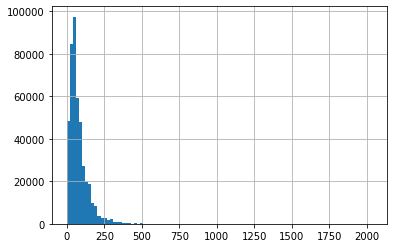

<AxesSubplot:>

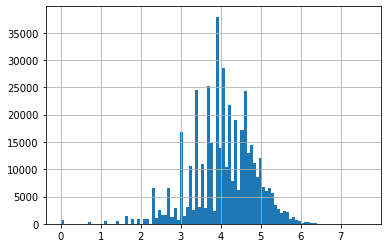

<Figure size 432x288 with 0 Axes>

In [29]:
show_monthly_pay_hist_and_log_hist(apart_lease_monthly_pay_df)

<AxesSubplot:>

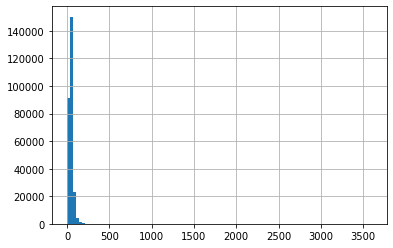

<AxesSubplot:>

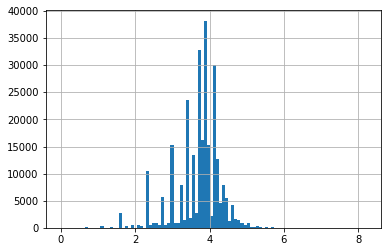

<Figure size 432x288 with 0 Axes>

In [30]:
show_monthly_pay_hist_and_log_hist(multiplex_lease_monthly_pay_df)

<AxesSubplot:>

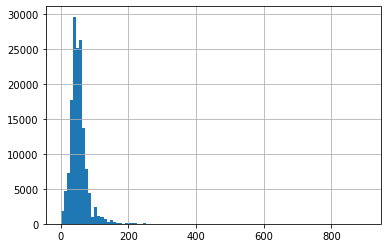

<AxesSubplot:>

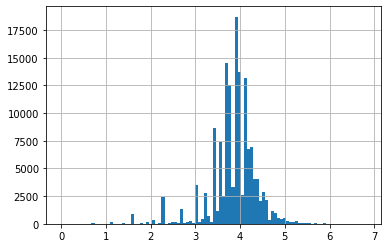

<Figure size 432x288 with 0 Axes>

In [31]:
show_monthly_pay_hist_and_log_hist(officetel_lease_monthly_pay_df)

In [32]:
def show_price_per_area_hist_and_log(df):
    df = df.copy()
    
    display(df['가격/면적'].hist(bins=100))
    plt.show()
    plt.clf()
    
    display(df['가격/면적'].apply(lambda x: np.log(x)).hist(bins=100))
    plt.show()
    plt.clf()

<AxesSubplot:>

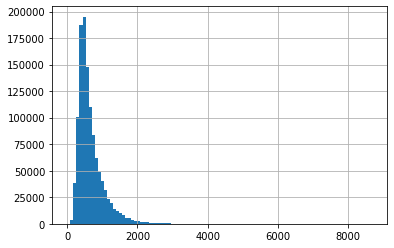

<AxesSubplot:>

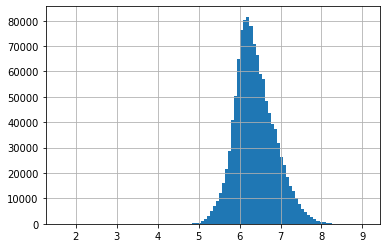

<Figure size 432x288 with 0 Axes>

In [33]:
show_price_per_area_hist_and_log(apart_trade_df)

<AxesSubplot:>

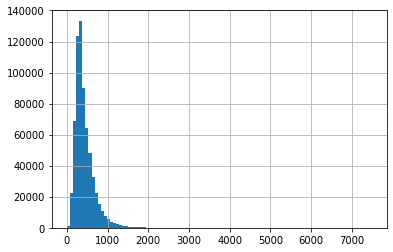

<AxesSubplot:>

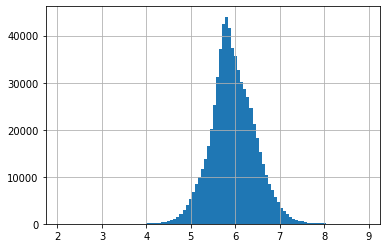

<Figure size 432x288 with 0 Axes>

In [34]:
show_price_per_area_hist_and_log(multiplex_trade_df)

<AxesSubplot:>

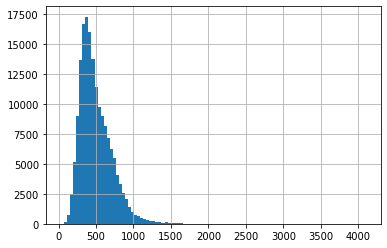

<AxesSubplot:>

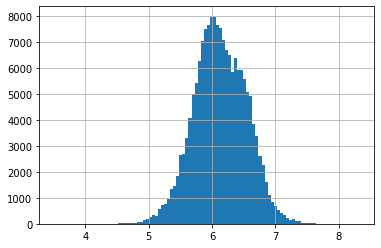

<Figure size 432x288 with 0 Axes>

In [35]:
show_price_per_area_hist_and_log(officetel_trade_df)

<AxesSubplot:>

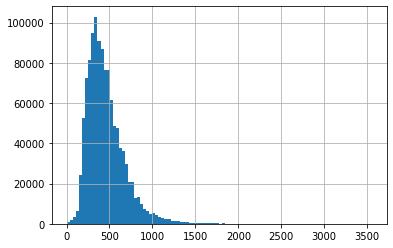

<AxesSubplot:>

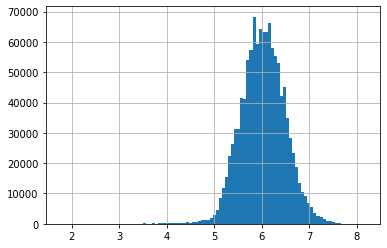

<Figure size 432x288 with 0 Axes>

In [36]:
show_price_per_area_hist_and_log(apart_lease_deposit_only_df)

<AxesSubplot:>

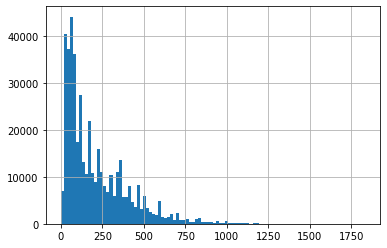

<AxesSubplot:>

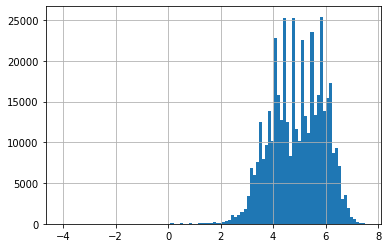

<Figure size 432x288 with 0 Axes>

In [37]:
show_price_per_area_hist_and_log(apart_lease_monthly_pay_df)

ValueError: supplied range of [10.121457489878543, inf] is not finite

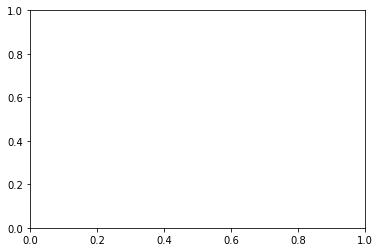

In [38]:
show_price_per_area_hist_and_log(multiplex_lease_deposit_only_df)

In [39]:
multiplex_lease_deposit_only_df['가격/면적'].describe()

count    5.309510e+05
mean              inf
std               NaN
min      1.012146e+01
25%      2.357795e+02
50%      3.394433e+02
75%      5.260641e+02
max               inf
Name: 가격/면적, dtype: float64

In [40]:
inf_df = multiplex_lease_deposit_only_df[multiplex_lease_deposit_only_df['가격/면적'] == np.inf]
inf_df.shape

(4, 19)

In [41]:
inf_df

,시군구,번지,본번,부번,건물명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구
239135,서울특별시 강동구 천호동,39-9,39,9,미래위너스,전세,0.0,201602,5,23000,0,3,2016,상암로 156,inf,2016,2,서울특별시,강동구
245317,서울특별시 관악구 봉천동,1589-10,1589,10,산아그린맨션,전세,0.0,201601,20,27500,0,4,1996,관악로5길 103,inf,2016,1,서울특별시,관악구
245605,서울특별시 관악구 봉천동,715-143,715,143,플렉스빌(715-143),전세,0.0,201601,22,5000,0,2,2001,보라매로6길 45-14,inf,2016,1,서울특별시,관악구
253324,서울특별시 동대문구 이문동,264-372,264,372,리더스빌,전세,0.0,201601,23,6000,0,1,2003,천장산로7길 64-10,inf,2016,1,서울특별시,동대문구


In [42]:
def remove_zero_area(df):
    df = df.copy()
    
    df = df[df['전용면적(㎡)'] != 0].reset_index(drop=True)
    
    return df

In [43]:
apart_trade_df = remove_zero_area(apart_trade_df)
apart_lease_df = remove_zero_area(apart_lease_df)
multiplex_trade_df = remove_zero_area(multiplex_trade_df)
multiplex_lease_df = remove_zero_area(multiplex_lease_df)
officetel_trade_df = remove_zero_area(officetel_trade_df)
officetel_lease_df = remove_zero_area(officetel_lease_df)

In [44]:
apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
apart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
multiplex_lease_deposit_only_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
multiplex_lease_monthly_pay_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
officetel_lease_deposit_only_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
officetel_lease_monthly_pay_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '월세'].reset_index(drop=True)

<AxesSubplot:>

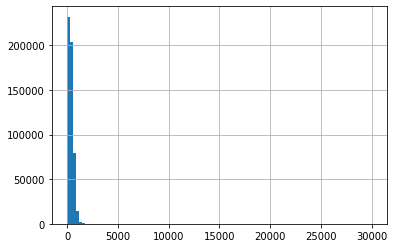

<AxesSubplot:>

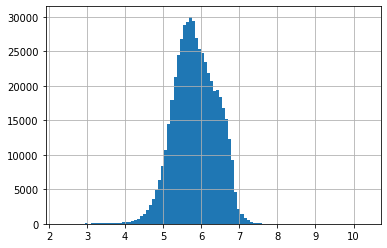

<Figure size 432x288 with 0 Axes>

In [45]:
show_price_per_area_hist_and_log(multiplex_lease_deposit_only_df)

<AxesSubplot:>

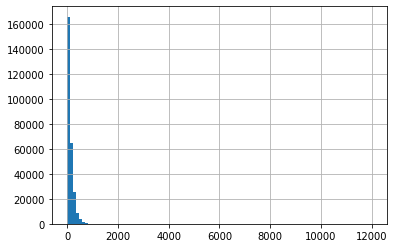

<AxesSubplot:>

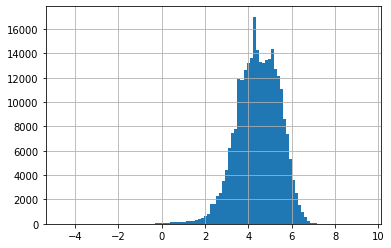

<Figure size 432x288 with 0 Axes>

In [46]:
show_price_per_area_hist_and_log(multiplex_lease_monthly_pay_df)

<AxesSubplot:>

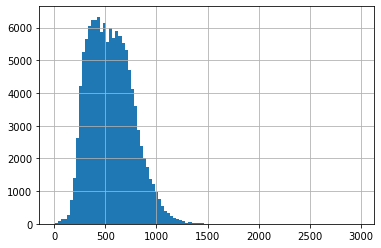

<AxesSubplot:>

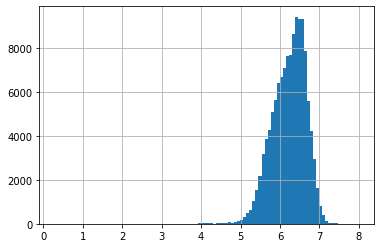

<Figure size 432x288 with 0 Axes>

In [47]:
show_price_per_area_hist_and_log(officetel_lease_deposit_only_df)

<AxesSubplot:>

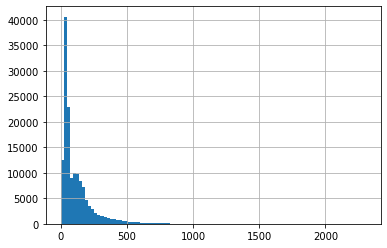

<AxesSubplot:>

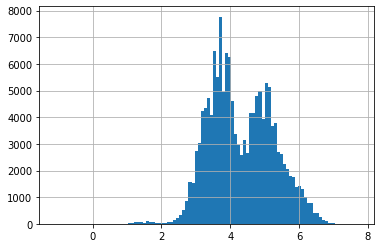

<Figure size 432x288 with 0 Axes>

In [49]:
show_price_per_area_hist_and_log(officetel_lease_monthly_pay_df)

In [50]:
def show_monthly_pay_per_area(df):
    df = df.copy()
    
    df['월세/면적'] = df['월세(만원)'] / df['전용면적(㎡)']
    
    display(df['월세/면적'].hist(bins=100))
    plt.show()
    plt.clf()
    
    display(df['월세/면적'].apply(lambda x: np.log(x)).hist(bins=100))
    plt.show()
    plt.clf()    

<AxesSubplot:>

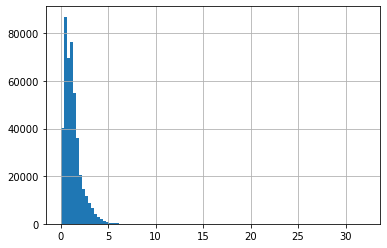

<AxesSubplot:>

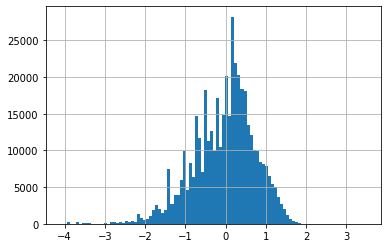

<Figure size 432x288 with 0 Axes>

In [51]:
show_monthly_pay_per_area(apart_lease_monthly_pay_df)

<AxesSubplot:>

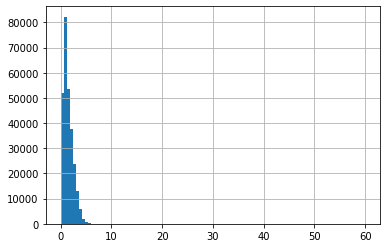

<AxesSubplot:>

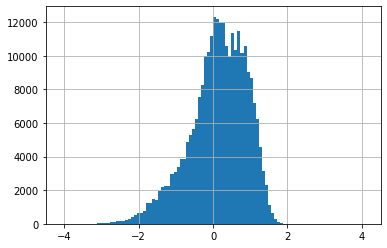

<Figure size 432x288 with 0 Axes>

In [52]:
show_monthly_pay_per_area(multiplex_lease_monthly_pay_df)

<AxesSubplot:>

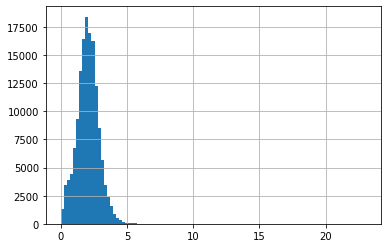

<AxesSubplot:>

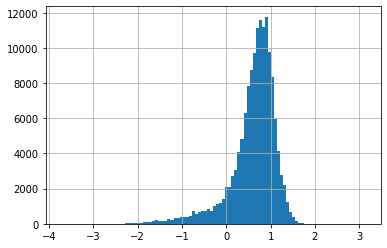

<Figure size 432x288 with 0 Axes>

In [53]:
show_monthly_pay_per_area(officetel_lease_monthly_pay_df)

In [54]:
officetel_lease_monthly_pay_df['월세(만원)'].describe()

count    146865.000000
mean         53.073142
std          27.570004
min           1.000000
25%          40.000000
50%          50.000000
75%          60.000000
max         900.000000
Name: 월세(만원), dtype: float64

In [55]:
min_df = officetel_lease_monthly_pay_df[officetel_lease_monthly_pay_df['월세(만원)'] == officetel_lease_monthly_pay_df['월세(만원)'].min()]
min_df.shape

(13, 19)

In [56]:
min_df

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구
19020,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,22.80,201301,12,6100,1,6,2003,버드나루로7길 12-22,267.543860,2013,1,서울특별시,영등포구
25070,서울특별시 구로구 오류동,11-3,11,3,그랑프리,월세,18.55,201405,8,6600,1,4,2013,경인로 193-17,355.795148,2014,5,서울특별시,구로구
76798,서울특별시 서대문구 대현동,37-32,37,32,영타운 지웰 에스테이트,월세,19.39,201712,27,15000,1,6,2017,이화여대5길 35,773.594636,2017,12,서울특별시,서대문구
89110,서울특별시 관악구 봉천동,874-19,874,19,\t(874-19)\t,월세,15.75,201804,2,6900,1,2,2004,봉천로 450-1,438.095238,2018,4,서울특별시,관악구
100699,서울특별시 영등포구 영등포동1가,20-1,20,1,대승프린스텔,월세,13.19,201801,12,6800,1,5,2001,경인로114길 26,515.542077,2018,1,서울특별시,영등포구
100704,서울특별시 영등포구 영등포동1가,20-1,20,1,대승프린스텔,월세,14.40,201808,4,7000,1,7,2001,경인로114길 26,486.111111,2018,8,서울특별시,영등포구
110026,서울특별시 관악구 봉천동,1568-2,1568,2,PRAVIDA 162,월세,19.82,201912,19,17000,1,13,2013,쑥고개로 125,857.719475,2019,12,서울특별시,관악구
128014,서울특별시 강동구 천호동,452-5,452,5,엘림스퀘어,월세,20.64,202002,16,18000,1,6,2018,천호대로161길 15,872.093023,2020,2,서울특별시,강동구
129925,서울특별시 강서구 마곡동,795-2,795,2,마곡아이파크,월세,24.22,202006,16,14000,1,7,2016,마곡중앙8로 90,578.034682,2020,6,서울특별시,강서구
132797,서울특별시 관악구 신림동,1414-33,1414,33,\t(1414-33)\t,월세,17.13,202006,14,8200,1,6,2003,남부순환로185길 26,478.692353,2020,6,서울특별시,관악구


In [57]:
min_addr_df = officetel_lease_monthly_pay_df[officetel_lease_monthly_pay_df['단지명'] == '\t(94-186)\t']
min_addr_df.shape

(27, 19)

In [58]:
min_addr_df

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구
10277,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,25.45,201211,24,2000,40,4,2003,버드나루로7길 12-22,78.585462,2012,11,서울특별시,영등포구
19020,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,22.80,201301,12,6100,1,6,2003,버드나루로7길 12-22,267.543860,2013,1,서울특별시,영등포구
19021,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,25.45,201306,24,2000,40,3,2003,버드나루로7길 12-22,78.585462,2013,6,서울특별시,영등포구
19022,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,22.16,201312,12,5000,10,3,2003,버드나루로7길 12-22,225.631769,2013,12,서울특별시,영등포구
30562,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,25.45,201409,1,6300,3,3,2003,버드나루로7길 12-22,247.544204,2014,9,서울특별시,영등포구
45755,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,22.80,201503,18,6200,3,3,2003,버드나루로7길 12-22,271.929825,2015,3,서울특별시,영등포구
45756,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,31.92,201510,21,6000,40,6,2003,버드나루로7길 12-22,187.969925,2015,10,서울특별시,영등포구
62422,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,25.45,201602,23,6000,10,2,2003,버드나루로7길 12-22,235.756385,2016,2,서울특별시,영등포구
62423,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,25.45,201608,25,6300,10,3,2003,버드나루로7길 12-22,247.544204,2016,8,서울특별시,영등포구
62424,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,월세,31.92,201609,1,8000,10,6,2003,버드나루로7길 12-22,250.626566,2016,9,서울특별시,영등포구


In [59]:
min_addr_deposit_only_df = officetel_lease_deposit_only_df[officetel_lease_deposit_only_df['단지명'] == '\t(94-186)\t']
min_addr_deposit_only_df.shape

(87, 19)

In [60]:
min_addr_deposit_only_df

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구
5196,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,22.16,201101,25,5500,0,2,2003,버드나루로7길 12-22,248.194946,2011,1,서울특별시,영등포구
5197,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,20.52,201102,21,5300,0,7,2003,버드나루로7길 12-22,258.284600,2011,2,서울특별시,영등포구
5198,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,25.45,201106,1,6000,0,3,2003,버드나루로7길 12-22,235.756385,2011,6,서울특별시,영등포구
5199,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,22.16,201106,20,6000,0,5,2003,버드나루로7길 12-22,270.758123,2011,6,서울특별시,영등포구
5200,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,31.92,201108,8,8200,0,6,2003,버드나루로7길 12-22,256.892231,2011,8,서울특별시,영등포구
5201,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,22.16,201108,16,6000,0,3,2003,버드나루로7길 12-22,270.758123,2011,8,서울특별시,영등포구
5202,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,25.45,201108,22,6200,0,2,2003,버드나루로7길 12-22,243.614931,2011,8,서울특별시,영등포구
5203,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,25.45,201109,29,5775,0,2,2003,버드나루로7길 12-22,226.915521,2011,9,서울특별시,영등포구
5204,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,22.80,201111,7,6200,0,5,2003,버드나루로7길 12-22,271.929825,2011,11,서울특별시,영등포구
5205,서울특별시 영등포구 영등포동7가,94-186,94,186,\t(94-186)\t,전세,22.80,201112,20,6000,0,5,2003,버드나루로7길 12-22,263.157895,2011,12,서울특별시,영등포구
